#Modelo Bayesiano - Riesgo crediticio

##Preparación del entorno

A continuación procedemos a instalar algunas librerias necesarias para el desarrollo del modelo.

In [ ]:
!pip install pymc3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 28.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of pymc3 to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.3 MB/s eta 0:00:00
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529959 sha256=049f268538b61d92911cd82398ea19c168282dfc23fd2ce30bd9ff2193eae9e8
  Stored in directory: /root/.cache/pip/wheels/fb/d3/25/6c443075ee21f3b6a59a6a180b55657b012722e1b89f8ccbe8
Successfully built theano-pymc


Ahora importamos las librerias necesarias.

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

##Carga y exploración preliminar de datos

En esta sección procedemos a cargar el conjunto de datos llamado German Credit Data, un conjunto utilizado para evaluar el riesgo crediticio de los clientes.


In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

columns = [
    'Status', 'Duration', 'CreditHistory', 'Purpose', 'CreditAmount', 'Savings',
    'EmploymentSince', 'InstallmentRate', 'PersonalStatusSex', 'OtherDebtors', 'PresentResidence',
    'Property', 'Age', 'OtherInstallmentPlans', 'Housing', 'ExistingCredits', 'Job',
    'NumLiablePeople', 'Telephone', 'ForeignWorker', 'Risk'
]

data = pd.read_csv(url, sep=' ', header=None, names=columns)

In [ ]:
# Convertimos la columna 'Risk' a tipo binario: 1 (riesgoso), 0 (no riesgoso)
data['Risk'] = data['Risk'].map({1: 1, 2: 0})

In [ ]:
data.head()

,Status,Duration,CreditHistory,Purpose,CreditAmount,Savings,EmploymentSince,InstallmentRate,PersonalStatusSex,OtherDebtors,...,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,NumLiablePeople,Telephone,ForeignWorker,Risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Status                 1000 non-null   object
 1   Duration               1000 non-null   int64 
 2   CreditHistory          1000 non-null   object
 3   Purpose                1000 non-null   object
 4   CreditAmount           1000 non-null   int64 
 5   Savings                1000 non-null   object
 6   EmploymentSince        1000 non-null   object
 7   InstallmentRate        1000 non-null   int64 
 8   PersonalStatusSex      1000 non-null   object
 9   OtherDebtors           1000 non-null   object
 10  PresentResidence       1000 non-null   int64 
 11  Property               1000 non-null   object
 12  Age                    1000 non-null   int64 
 13  OtherInstallmentPlans  1000 non-null   object
 14  Housing                1000 non-null   object
 15  ExistingCredits       

##Visualización

Ahora, vamos a visualizar la distribución de las variables más importantes y su relación con el riesgo.

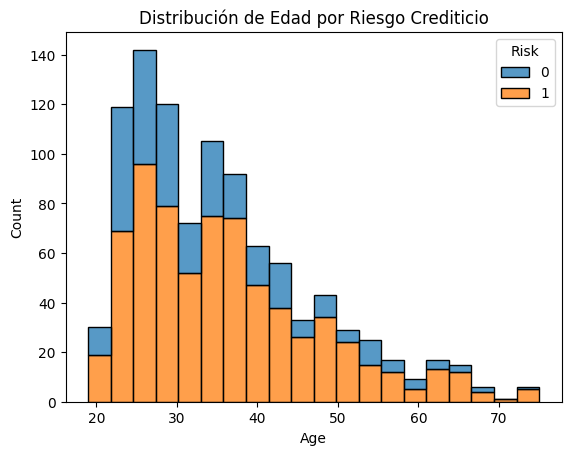

In [ ]:
sns.histplot(data, x='Age', hue='Risk', multiple='stack', bins=20)
plt.title('Distribución de Edad por Riesgo Crediticio')
plt.show()

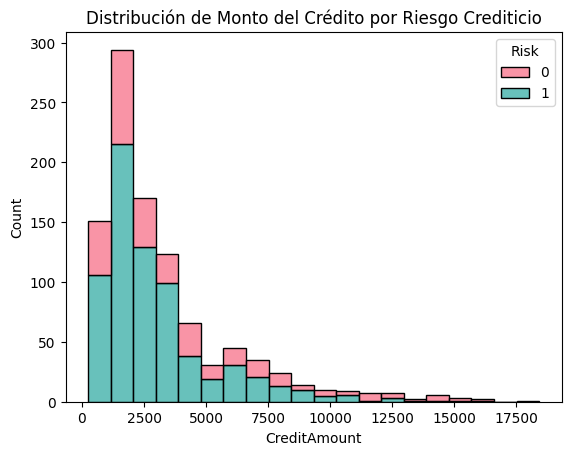

In [ ]:
sns.histplot(data, x='CreditAmount', hue='Risk', multiple='stack', bins=20, palette="husl")
plt.title('Distribución de Monto del Crédito por Riesgo Crediticio')
plt.show()

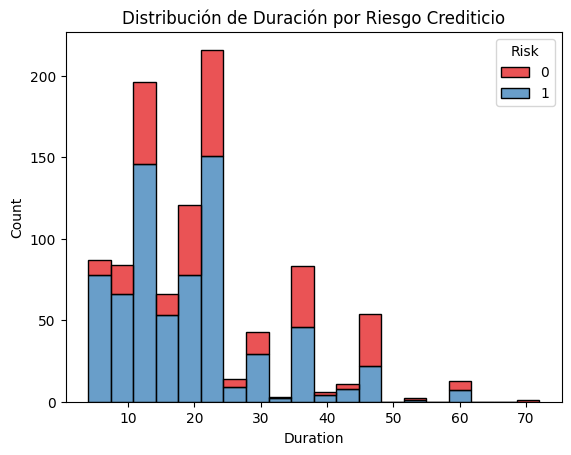

In [ ]:
sns.histplot(data, x='Duration', hue='Risk', multiple='stack', bins=20, palette="Set1")
plt.title('Distribución de Duración por Riesgo Crediticio')
plt.show()

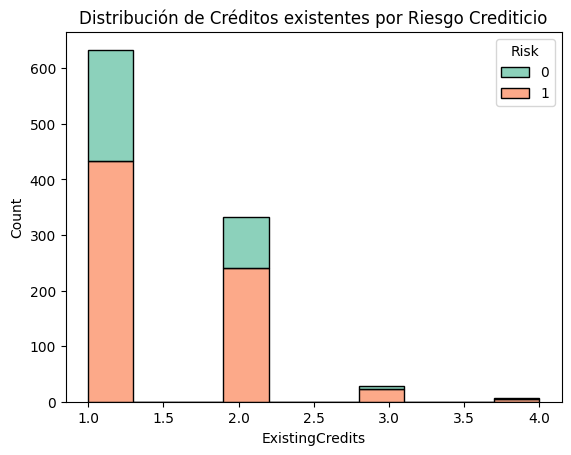

In [ ]:
sns.histplot(data, x='ExistingCredits', hue='Risk', multiple='stack', bins=10, palette="Set2")
plt.title('Distribución de Créditos existentes por Riesgo Crediticio')
plt.show()

In [ ]:
# Vamos a hacer un mapeo de la variable Job para que sea mas clara la info de la gráfica
mapping = {
    'A171': 'no cualificado - desempleado',
    'A172': 'no cualificado - residente',
    'A173': 'empleado cualificado',
    'A174': 'empleado altamente cualificado'
}

# Reemplaza los valores en la columna con las descripciones utilizando el método replace().
data['Job'] = data['Job'].replace(mapping)


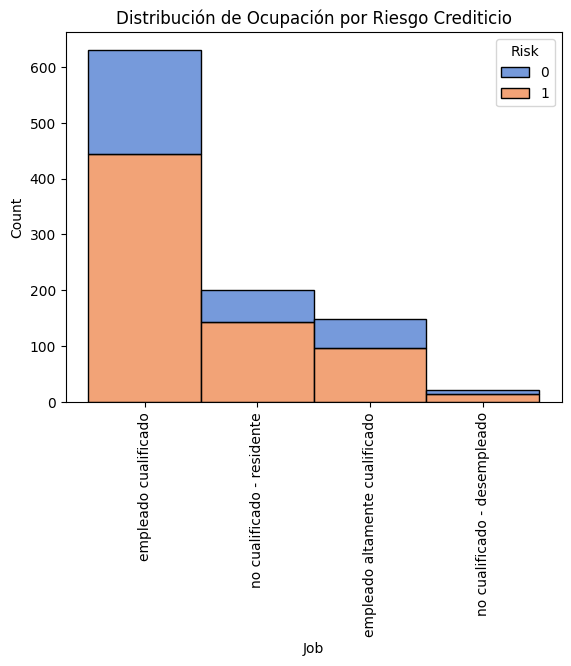

In [ ]:
sns.histplot(data, x='Job', hue='Risk', multiple='stack', bins=20, palette="muted")
plt.title('Distribución de Ocupación por Riesgo Crediticio')
plt.xticks(rotation=90)
plt.show()

##Preprocesamiento

In [ ]:
# Seleccionamos las variables numéricas que serán utilizadas en el modelo.
features = ['Age', 'CreditAmount', 'Duration']

# Escalamos estas variables para mejorar la estabilidad del modelo.
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

# Definimos las variables independientes (X) y la variable dependiente (y)
X = data_scaled
y = data['Risk'].values

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##Modelo Bayesiano

En este punto vamos a definir nuestro modelo bayesiano utilizando PyMC3. Este modelo predice la probabilidad de que un cliente sea riesgoso en base a su edad, monto del crédito y duración del préstamo.


In [ ]:
with pm.Model() as modelo_crediticio:
    # Definimos las distribuciones a priori para los coeficientes y el intercepto
    alpha = pm.Normal('alpha', mu=0, sigma=10)  # Intercepto
    betas = pm.Normal('betas', mu=0, sigma=10, shape = X_train.shape[1])  # Coeficientes para cada variable

    # Calculamos la probabilidad de riesgo usando una función logística
    p = pm.math.sigmoid(alpha + pm.math.dot(X_train, betas))

    # Definimos la variable observada: si el cliente es riesgoso o no (modelo Bernoulli)
    y_obs = pm.Bernoulli('y_obs', p = p, observed = y_train)

    # Ejecutamos la inferencia mediante MCMC para obtener la distribución posterior
    traza = pm.sample(2000, tune = 1000, target_accept = 0.9, return_inferencedata = True)

Output()

##Evaluación del modelo

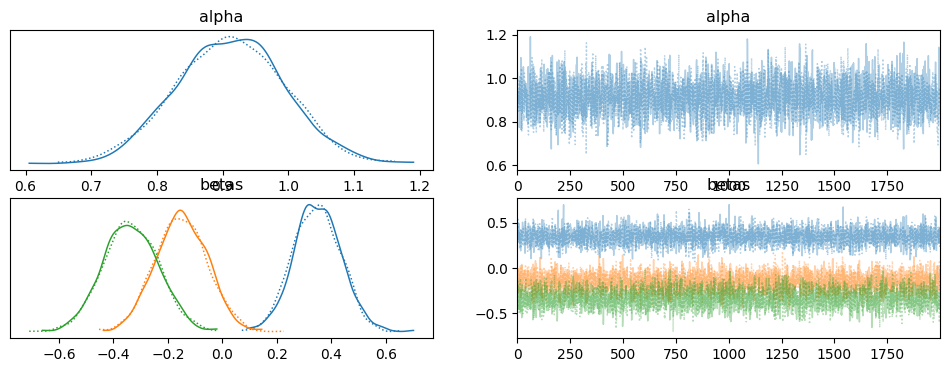

In [ ]:
# Evaluamos la calidad del modelo visualizando las trazas de los parámetros.
az.plot_trace(traza)
plt.show()

* El modelo ha convergido correctamente, ya que las trazas no muestran tendencias ni saltos bruscos.
* La distribución de los coeficientes es clara, lo que indica que el modelo ha encontrado relaciones entre las variables y el riesgo crediticio.
* Los coeficientes con valores negativos indican que esas variables reducen la probabilidad de riesgo crediticio, mientras que los positivos la aumentan.

In [ ]:
# Resumen de la inferencia que nos muestra los valores más probables de los parámetros y su incertidumbre
resumen = az.summary(traza, round_to=2)
print(resumen)

          mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha     0.91  0.08    0.75     1.06        0.0      0.0   3356.06   2509.48   
betas[0]  0.35  0.09    0.19     0.51        0.0      0.0   3600.92   3117.71   
betas[1] -0.15  0.09   -0.33     0.02        0.0      0.0   3459.15   3006.63   
betas[2] -0.34  0.10   -0.53    -0.15        0.0      0.0   3107.68   2852.17   

          r_hat  
alpha       1.0  
betas[0]    1.0  
betas[1]    1.0  
betas[2]    1.0  


*Interpretación:*

* El modelo ha convergido bien (r_hat = 1.0).
* betas[0] y betas[2] son significativos, lo que indica que estas variables afectan la predicción.
* betas[1] no es concluyente, ya que su intervalo de credibilidad incluye el 0. Podríamos considerar eliminar esta variable o explorar más datos.
* Los intervalos de credibilidad son razonables, lo que sugiere que la inferencia bayesiana ha capturado bien la incertidumbre en las estimaciones.